# Drizzling WFPC2 Images to use a Single Zeropoint

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

Extra care must be taken when using `AstroDrizzle` to combine observations from detectors comprised of multiple chips of varying sensitivity. `AstroDrizzle` works with calibrated images in units of counts (electrons or Data Numbers) or count rates and not in units of flux. It assumes that all input frames can be converted to physical flux units using a single inverse-sensitivity factor, recorded in the FITS image headers as `PHOTFLAM`, and the output drizzled product simply copies the `PHOTFLAM` keyword value from the first input image. When this occurs, the inverse-sensitivity will vary across the final drizzled product, and users will need to keep track of which sources fell on which chip when doing photometry. Moreover, varying detector sensitivities will affect the cosmic-ray rejection algorithm used by `AstroDrizzle`, and this may result in the misidentification of some good pixels as cosmic rays.

This is a typical situation when drizzle-combining images from HST instruments with different chip sensitivities, e.g. Wide Field and Planetary Camera 2 (WFPC2). For more detail, see the section on [Gain Variation](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch53.html) under 'Position-Dependent Photometric Corrections' in the WFPC2 Data Handbook. As a result, each of the four chips requires a [unique PHOTFLAM](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch52.html#1933986) header keyword value. A similar situation may occur when drizzle-combining observations taken over a span of several years as detector's sensitivity declines over time, see e.g. [ACS ISR 2016-03](https://doi.org/10.3847/0004-6256/152/3/60).

One approach is to rescale the input data so that `AstroDrizzle` can properly assume the images/chips have the same sensitivity; that is, a single `PHOTFLAM` value can be used to convert re-scaled image counts (or count-rates) to physical _integrated_ flux units. The `photeq` task in `Drizzlepac` automates this image intensity rescaling to a single inverse-sensitivity factor `PHOTFLAM`.

In this example notebook, archival WFPC2 images are used to demonstrate advanced reprocessing using `TweakReg` and `AstroDrizzle` for alignment and image combination. The notebook is based on a prior WFPC2 [example](http://www.stsci.edu/hst/HST_overview/drizzlepac/examples/example7) but includes additional information about equalizing the chip sensitivities prior to combining. 

**NOTE:** It is important to note that `photeq` only adjusts image counts so that _integrated_ physical fluxes can be obtained using a single `PHOTFLAM`. It does nothing to account for different throughtputs at different wavelengths.

In [1]:
import shutil
import glob
import os
import subprocess

import matplotlib.pyplot as plt
from astropy.io import fits

from astroquery.mast import Observations
from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq
from stsci.skypac import skymatch

# ONLY needed for the simulation section:
import numpy as np
from stwcs.wcsutil import HSTWCS
from drizzlepac.wfpc2Data import WFPC2_GAINS

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## 1. Download the Data

This example uses WFPC2 observations of Messier 2 in the F814W filter. The data come from GO proposal [11100](http://www.stsci.edu/cgi-bin/get-proposal-info?id=11100&observatory=HST) _"Two new 'bullets' for MOND: revealing the properties of dark matter in massive merging clusters"_. Four images were acquired using a 4-pt dither box pattern, followed by two images offset with a dither-line pattern. 

The data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

In [2]:
# Retrieve the observation information.
if os.path.isdir('mastDownload'):
    shutil.rmtree('mastDownload')
obs_table = Observations.query_criteria(obs_id='ua0605*', filters='F814W', obstype='ALL')
products = Observations.get_product_list(obs_table)

# Download only the ua0605*_c0m.fits and ua0605*_c1m.fits (DQ) images:
Observations.download_products(products, mrp_only=False, productSubGroupDescription=['C0M', 'C1M'], extension='fits')

# Move the files from the mastDownload directory to the current working
# directory and make a backup of the files.
fits_files = glob.glob('mastDownload/HST/ua*/ua*c?m.fits')
for fil in fits_files:
    base_name = os.path.basename(fil)
    if os.path.isfile(base_name):
        os.remove(base_name)
    shutil.move(fil, '.')
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


## 2. Update the WCS

WFPC2 images downloaded from the archive contain World Coordinate System (WCS) information based on an older-style description of image distortions. Before these images can be processed with `drizzlepac`, their WCS must be converted to a new format. This can be achieved using `updatewcs()` function from the `stwcs` package. More details may be found here: ['Making WFPC2 Images Compatible with AstroDrizzle'](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/ch45.html#601857). Note that `updatewcs` is no longer a parameter in AstroDrizzle or TweakReg and must be run separately before processing the data. 

First we download the reference files from the CRDS website. See the initialization notebook in this repository for more information.  

In [3]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))

subprocess.check_output('crds bestrefs --files ua0605*_c0m.fits --sync-references=1 --update-bestrefs', shell=True)

os.environ['uref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfpc2')) + os.path.sep

**NOTE:** This next step may raise warnings because the Astrometry database is in progress and currently does not cover the entire sky. Please ignore these warnings. The WCS will still be updated.  

In [4]:
updatewcs('ua*c0m.fits', use_db=True)

- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


 No new solution found in AstrometryDB.


 Updating database with initial WCS ua060502m


Problem encountered when adding ua060502m to database


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


 No new solution found in AstrometryDB.


 Updating database with initial WCS ua060504m


Problem encountered when adding ua060504m to database


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


 No new solution found in AstrometryDB.


 Updating database with initial WCS ua060506m


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


Problem encountered when adding ua060506m to database


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


 No new solution found in AstrometryDB.


 Updating database with initial WCS ua060508m


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


Problem encountered when adding ua060508m to database


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


 No new solution found in AstrometryDB.


 Updating database with initial WCS ua06050am


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


Problem encountered when adding ua06050am to database


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


 No new solution found in AstrometryDB.


 Updating database with initial WCS ua06050cm


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


Problem encountered when adding ua06050cm to database


['ua060502m_c0m.fits',
 'ua060504m_c0m.fits',
 'ua060506m_c0m.fits',
 'ua060508m_c0m.fits',
 'ua06050am_c0m.fits',
 'ua06050cm_c0m.fits']

### Backup an Image

In a later section we will generate simulated data to illustrate the effects of drizzling WFPC2 images without sensitivity equalization. For that purpose we will need a copy of an original image that has the original inverse-sensitivity values (`PHOTFLAM`) in their headers. Here we create a backup copy of the first image.

**NOTE:** This step is needed for illustration purpose in this notebook only. It is not needed when processing data.

In [5]:
orig_image = glob.glob('ua*c0m.fits')[0]
backup_image = 'simulation.fits'
if os.path.isfile(backup_image):
    os.remove(backup_image)
shutil.copy2(orig_image, backup_image)

'simulation.fits'

## 3. Align the Images

Due to small pointing errors, the image header WCS typically needs to be updated in order to achieve the best drizzle-combined products. The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Appendix B](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/AppendixB2.html). Input images must first be aligned so that when the coordinates of a given object (in detector space) are converted to sky coordinates (using the WCS), that object's sky coordinates must be approximately equal in each frame. 

The `DrizzlePac` task `TweakReg` may be used to correct for any errors in the image header WCS. First, `TweakReg` finds sources in each image, matches sources in common across images, and finds a separate linear transformation to align each image. `TweakReg` then computes a new WCS for each image based on this linear transformation.

Here we show a basic image alignment procedure. For a more detailed illustration of image alignment, please refer to other example notebooks such as the mosaic example in this repository.

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 05:06:56.022 (08/01/2019) 


Version Information


--------------------


Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.1 


stwcs Version -> 1.4.2 


Finding shifts for: 


    ua060502m_c0m.fits


    ua060504m_c0m.fits


    ua060506m_c0m.fits


    ua060508m_c0m.fits


    ua06050am_c0m.fits


    ua06050cm_c0m.fits


===  Source finding for image 'ua060502m_c0m.fits':


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 1) started at: 05:06:56.138 (08/01/2019)


     Found 14 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 2) started at: 05:06:56.203 (08/01/2019)


     Found 83 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 3) started at: 05:06:56.272 (08/01/2019)


     Found 304 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 4) started at: 05:06:56.370 (08/01/2019)


     Found 116 objects.


===  FINAL number of objects in image 'ua060502m_c0m.fits': 517


===  Source finding for image 'ua060504m_c0m.fits':


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 1) started at: 05:06:56.683 (08/01/2019)


     Found 13 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 2) started at: 05:06:56.742 (08/01/2019)


     Found 75 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 3) started at: 05:06:56.839 (08/01/2019)


     Found 407 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 4) started at: 05:06:56.952 (08/01/2019)


     Found 237 objects.


===  FINAL number of objects in image 'ua060504m_c0m.fits': 732


===  Source finding for image 'ua060506m_c0m.fits':


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 1) started at: 05:06:57.325 (08/01/2019)


     Found 19 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 2) started at: 05:06:57.389 (08/01/2019)


     Found 76 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 3) started at: 05:06:57.464 (08/01/2019)


     Found 241 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 4) started at: 05:06:57.608 (08/01/2019)


     Found 105 objects.


===  FINAL number of objects in image 'ua060506m_c0m.fits': 441


===  Source finding for image 'ua060508m_c0m.fits':


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 1) started at: 05:06:57.933 (08/01/2019)


     Found 15 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 2) started at: 05:06:58.018 (08/01/2019)


     Found 130 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 3) started at: 05:06:58.128 (08/01/2019)


     Found 280 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 4) started at: 05:06:58.256 (08/01/2019)


     Found 411 objects.


===  FINAL number of objects in image 'ua060508m_c0m.fits': 836


===  Source finding for image 'ua06050am_c0m.fits':


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 1) started at: 05:06:58.595 (08/01/2019)


     Found 26 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 2) started at: 05:06:58.658 (08/01/2019)


     Found 187 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 3) started at: 05:06:58.74 (08/01/2019)


     Found 301 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 4) started at: 05:06:58.851 (08/01/2019)


     Found 130 objects.


===  FINAL number of objects in image 'ua06050am_c0m.fits': 644


===  Source finding for image 'ua06050cm_c0m.fits':


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 1) started at: 05:06:59.21 (08/01/2019)


     Found 30 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 2) started at: 05:06:59.278 (08/01/2019)


     Found 67 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 3) started at: 05:06:59.361 (08/01/2019)


     Found 512 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 4) started at: 05:06:59.490 (08/01/2019)


     Found 282 objects.


===  FINAL number of objects in image 'ua06050cm_c0m.fits': 891


Performing alignment in the projection plane defined by the WCS


derived from 'ua060502m_c0m.fits'


Performing fit for: ua060504m_c0m.fits


Matching sources from 'ua060504m_c0m.fits' with sources from reference image 'ua060502m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.6210447229745029 -0.5585447229745029


    with significance of  309.3184263649498 and  10.0  matches


Found 37 matches for ua060504m_c0m.fits...


Computed  rscale  fit for  ua060504m_c0m.fits : 


XSH: 0.1209  YSH: 0.0494    ROT: 0.001963096717    SCALE: 1.000024


XRMS: 0.1    YRMS: 0.15


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 1.7e-06 (deg)


Final solution based on  35  objects.


wrote XY data to:  ua060504m_c0m_catalog_fit.match


Total # points:  35


# of points after clipping:  35


Total # points:  35


# of points after clipping:  35


Initializing new WCSCORR table for  ua060504m_c0m.fits


....Updating header for ua060504m_c0m.fits...


Processing ua060504m_c0m.fits['SCI',1]


Updating header for ua060504m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4613420547765364e-06 -1.2409397670071448e-05


CD_21  CD_22: -1.2410993102562787e-05 -2.4758072626667208e-06


CRVAL    : 323.3149429482253 -0.87045480302202


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555083662150902


ORIENTAT : -101.28297180908855


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',2]


Updating header for ua060504m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.709233924531277e-05 -5.647944232439503e-06


CD_21  CD_22: -5.64562063694134e-06 2.708902915875212e-05


CRVAL    : 323.30621040229966 -0.8561631001971867


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962994467192775


ORIENTAT : -11.777200811774534


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',3]


Updating header for ua060504m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.500422418017306e-06 2.711722804656734e-05


CD_21  CD_22: 2.7116526401163916e-05 5.496961452804467e-06


CRVAL    : 323.3266480087841 -0.8521698769492949


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960995931741483


ORIENTAT : 78.54078891010785


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',4]


Updating header for ua060504m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7182689654195126e-05 5.23958845869805e-06


CD_21  CD_22: 5.234492690031329e-06 -2.718734478529472e-05


CRVAL    : 323.3308662366182 -0.8730797567941792


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965795192206055


ORIENTAT : 169.09160556012728


WCSNAME  :  TWEAK


Performing fit for: ua060506m_c0m.fits


Matching sources from 'ua060506m_c0m.fits' with sources from reference image 'ua060502m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.204378056307835 -0.204378056307835


    with significance of  349.6821413798537 and  16.0  matches


Found 35 matches for ua060506m_c0m.fits...


Computed  rscale  fit for  ua060506m_c0m.fits : 


XSH: 0.0966  YSH: 0.1779    ROT: 359.9975265    SCALE: 0.999977


XRMS: 0.16    YRMS: 0.15


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.3e-06 (deg)


Final solution based on  35  objects.


wrote XY data to:  ua060506m_c0m_catalog_fit.match


Total # points:  35


# of points after clipping:  35


Total # points:  35


# of points after clipping:  35


Initializing new WCSCORR table for  ua060506m_c0m.fits


....Updating header for ua060506m_c0m.fits...


Processing ua060506m_c0m.fits['SCI',1]


Updating header for ua060506m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.462394545169971e-06 -1.2409657484255432e-05


CD_21  CD_22: -1.2411254119597085e-05 -2.476860107199316e-06


CRVAL    : 323.31541886726455 -0.8700065074225689


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555034216237082


ORIENTAT : -101.28741650780512


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',2]


Updating header for ua060506m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7092887898303537e-05 -5.650251492671705e-06


CD_21  CD_22: -5.647927990109191e-06 2.7089577522820153e-05


CRVAL    : 323.306684895524 -0.8557149615134191


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962886308997655


ORIENTAT : -11.781645668274452


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',3]


Updating header for ua060506m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.502726251271185e-06 2.7117789146737585e-05


CD_21  CD_22: 2.7117087193187415e-05 5.499265235911721e-06


CRVAL    : 323.32712293407315 -0.8517200075499368


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960887789026077


ORIENTAT : 78.53634438936692


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',4]


Updating header for ua060506m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7183273457505914e-05 5.2418883222376134e-06


CD_21  CD_22: 5.23679201867377e-06 -2.7187928409141773e-05


CRVAL    : 323.3313429372871 -0.8726303216674192


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.0996568700276385


ORIENTAT : 169.08716101302855


WCSNAME  :  TWEAK


Performing fit for: ua060508m_c0m.fits


Matching sources from 'ua060508m_c0m.fits' with sources from reference image 'ua060502m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.189672173954893 -0.336730997484306


    with significance of  330.2553557476396 and  14.0  matches


Found 32 matches for ua060508m_c0m.fits...


Computed  rscale  fit for  ua060508m_c0m.fits : 


XSH: 0.1437  YSH: 0.0013    ROT: 0.0003824316375    SCALE: 0.999924


XRMS: 0.18    YRMS: 0.097


RMS_RA: 7.8e-07 (deg)   RMS_DEC: 2.4e-06 (deg)


Final solution based on  31  objects.


wrote XY data to:  ua060508m_c0m_catalog_fit.match


Total # points:  31


# of points after clipping:  31


Total # points:  31


# of points after clipping:  31


Initializing new WCSCORR table for  ua060508m_c0m.fits


....Updating header for ua060508m_c0m.fits...


Processing ua060508m_c0m.fits['SCI',1]


Updating header for ua060508m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4618754253073584e-06 -1.2410292504763368e-05


CD_21  CD_22: -1.2411888420552544e-05 -2.476341780778667e-06


CRVAL    : 323.31518689504884 -0.8706171908685794


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.045549817686568114


ORIENTAT : -101.28455241338322


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',2]


Updating header for ua060508m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7094286183016428e-05 -5.6491300174005625e-06


CD_21  CD_22: -5.646806260031928e-06 2.7090975790121793e-05


CRVAL    : 323.3064532766626 -0.856324619736744


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962771605323506


ORIENTAT : -11.778781571480012


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',3]


Updating header for ua060508m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.5015974894208175e-06 2.7119181014490515e-05


CD_21  CD_22: 2.7118479173139918e-05 5.498136244482757e-06


CRVAL    : 323.3268923600176 -0.8523305227668846


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960773111614668


ORIENTAT : 78.53920825073658


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',4]


Updating header for ua060508m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7184654916855897e-05 5.240745276564736e-06


CD_21  CD_22: 5.235648942860424e-06 -2.718931028966539e-05


CRVAL    : 323.3311114923944 -0.8732419090929704


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965572280724205


ORIENTAT : 169.09002476220402


WCSNAME  :  TWEAK


Performing fit for: ua06050am_c0m.fits


Matching sources from 'ua06050am_c0m.fits' with sources from reference image 'ua060502m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.17059427252405257 -0.6976212995510771


    with significance of  337.88089617496877 and  12.0  matches


Found 38 matches for ua06050am_c0m.fits...


Computed  rscale  fit for  ua06050am_c0m.fits : 


XSH: 0.0784  YSH: 0.0282    ROT: 359.9969155    SCALE: 0.999930


XRMS: 0.22    YRMS: 0.18


RMS_RA: 1.7e-06 (deg)   RMS_DEC: 3.2e-06 (deg)


Final solution based on  34  objects.


wrote XY data to:  ua06050am_c0m_catalog_fit.match


Total # points:  34


# of points after clipping:  34


Total # points:  34


# of points after clipping:  34


Initializing new WCSCORR table for  ua06050am_c0m.fits


....Updating header for ua06050am_c0m.fits...


Processing ua06050am_c0m.fits['SCI',1]


Updating header for ua06050am_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4625885663866415e-06 -1.2409951479974878e-05


CD_21  CD_22: -1.2411548232649643e-05 -2.4770545276654057e-06


CRVAL    : 323.31476267518923 -0.8709932462013605


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554940414591529


ORIENTAT : -101.28801920481457


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',2]


Updating header for ua06050am_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.709352705738692e-05 -5.650682098316652e-06


CD_21  CD_22: -5.648358631654976e-06 2.7090216571628005e-05


CRVAL    : 323.30602832559873 -0.8567014236586943


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962681151535628


ORIENTAT : -11.78224827207692


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',3]


Updating header for ua06050am_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.503153605721683e-06 2.7118430477665538e-05


CD_21  CD_22: 2.7117728498549386e-05 5.499692494902141e-06


CRVAL    : 323.32646685435225 -0.8527061516472279


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960682680751902


ORIENTAT : 78.53574126523685


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',4]


Updating header for ua06050am_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7183919292574183e-05 5.242309692637681e-06


CD_21  CD_22: 5.237213201060637e-06 -2.7188574242661314e-05


CRVAL    : 323.3306871876108 -0.8736169605261175


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965481785256511


ORIENTAT : 169.08655786377412


WCSNAME  :  TWEAK


Performing fit for: ua06050cm_c0m.fits


Matching sources from 'ua06050cm_c0m.fits' with sources from reference image 'ua060502m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.17937805630783643 -0.704378056307835


    with significance of  315.210735369701 and  11.0  matches


Found 36 matches for ua06050cm_c0m.fits...


Computed  rscale  fit for  ua06050cm_c0m.fits : 


XSH: 0.0674  YSH: -0.0543    ROT: 359.9998063    SCALE: 0.999891


XRMS: 0.2    YRMS: 0.17


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 2.9e-06 (deg)


Final solution based on  35  objects.


wrote XY data to:  ua06050cm_c0m_catalog_fit.match


Total # points:  35


# of points after clipping:  35


Total # points:  35


# of points after clipping:  35


Initializing new WCSCORR table for  ua06050cm_c0m.fits


....Updating header for ua06050cm_c0m.fits...


Processing ua06050cm_c0m.fits['SCI',1]


Updating header for ua06050cm_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4620498740175054e-06 -1.2410517720715758e-05


CD_21  CD_22: -1.241211386174527e-05 -2.476516492642756e-06


CRVAL    : 323.31499061603364 -0.8703826189689075


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554921252610055


ORIENTAT : -101.28512859285529


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',2]


Updating header for ua06050cm_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7094775566098846e-05 -5.6495162781401355e-06


CD_21  CD_22: -5.647192523648942e-06 2.709146501007651e-05


CRVAL    : 323.3062566784178 -0.8560898475624878


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962639245354485


ORIENTAT : -11.779357673119042


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',3]


Updating header for ua06050cm_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.5019810122225615e-06 2.7119672366760744e-05


CD_21  CD_22: 2.7118970499931074e-05 5.498519737794166e-06


CRVAL    : 323.32669613233264 -0.8520954645972213


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960640775867557


ORIENTAT : 78.53863218354479


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',4]


Updating header for ua06050cm_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7185150231430877e-05 5.241124286998136e-06


CD_21  CD_22: 5.23602778815388e-06 -2.7189805622909153e-05


CRVAL    : 323.33091555976023 -0.8730072300019479


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965439873691254


ORIENTAT : 169.08944868664412


WCSNAME  :  TWEAK


Initializing new WCSCORR table for  ua060502m_c0m.fits


Trailer file written to:  tweakreg.log


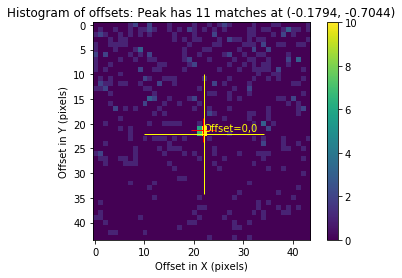

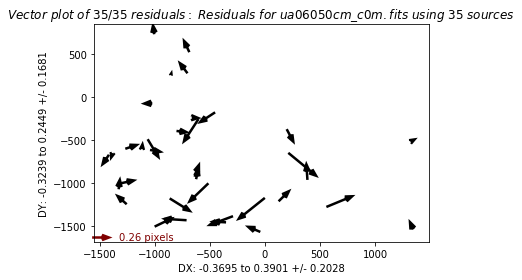

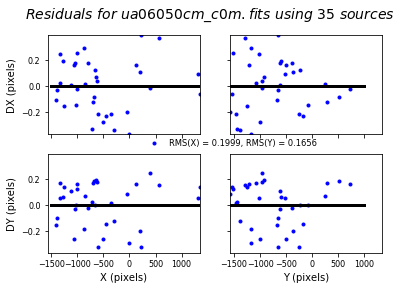

In [6]:
tweakreg.TweakReg('ua*c0m.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

## 4. Equalize the chip sensitivities

This step adjusts image data values so that all images and chips appear (to `AstroDrizzle`) to have a single inverse sensitivity (`PHOTFLAM`). This can be achieved using the `photeq` task in `Drizzlepac`. This task adjusts image data so that when these data are multiplied by the same single `PHOTFLAM` value, the correct flux is obtained.

In [7]:
photeq.photeq(files='ua*_c0m.fits', ref_phot_ext=3, readonly=False)

***** drizzlepac.photeq started on 2019-01-08 05:07:06.477373


      Version 0.2 (06-Nov-2015)


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'ua060502m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060504m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060506m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060508m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)

     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050am_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050cm_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


In the above command, we instruct `photeq` to "equalize" all chips of all input images using the `PHOTFLAM` for the `WF3` chip (`ref_phot_ext=3`), using the first image as a reference. This reference `PHOTFLAM` value is reported in the log file:

```
REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits['SCI',1]'
REFERENCE 'PHOTFLAM' VALUE IS: 2.507987e-18
```

Upon the completion, `photeq` will not only adjust image data but also update `PHOTFLAM` values for all chips to this specific reference value.

## 5. Drizzle-combine the images

All four chips are now drizzled together with an output pixel scale set to that of the WF chips:

In [8]:
astrodrizzle.AstroDrizzle('ua*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996)

Setting up logfile :  astrodrizzle.log


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:07:06.952 (08/01/2019)


==== Processing Step  Initialization  started at  05:07:06.953 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3186637049091  -0.8646727774421499  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1555  1534


********************************************************************************


*


*  Estimated memory usage:  up to 257 Mb.


*  Output image size:       1555 X 1534 pixels. 


*  Output image file:       ~ 27 Mb. 


*  Cores available:         8


*


********************************************************************************


==== Processing Step  Initialization  finished at  05:07:09.536 (08/01/2019)


==== Processing Step  Static Mask  started at  05:07:09.539 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:07:09.965 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:07:09.967 (08/01/2019)


***** skymatch started on 2019-01-08 05:07:10.732942


      Version 0.9.15 (2018-07-03 21:07:36 -0400)


'skymatch' task will apply computed sky differences to input image file(s).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


'MDRIZSKY' header keyword will represent sky value *computed* from data.


-----  User specified keywords:  -----


       Sky Value Keyword:  'MDRIZSKY'


       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----


   **  Input image: 'ua060502m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060502m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060502m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060502m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060502m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua060504m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060504m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060504m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060504m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060504m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua060506m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060506m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060506m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060506m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060506m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua060508m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060508m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060508m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060508m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060508m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua06050am_c0m.fits'


       EXT: 'SCI',1;	MASK: ua06050am_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua06050am_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua06050am_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua06050am_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua06050cm_c0m.fits'


       EXT: 'SCI',1;	MASK: ua06050cm_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua06050cm_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua06050cm_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua06050cm_skymatch_mask_sci4.fits[0]


-----  Sky statistics parameters:  -----


       statistics function: 'median'


       lower = None


       upper = None


       nclip = 5


       lsigma = 4.0


       usigma = 4.0


       binwidth = 0.1


-----  Data->Brightness conversion parameters for input files:  -----


   *   Image: ua060502m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua060504m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua060506m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua060508m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua06050am_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua06050cm_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


-----  Computing sky values requested image extensions (detector chips):  -----


   *   Image:   'ua060502m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -17.481034058661276 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.362681   NEW MDRIZSKY = -0.362681


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.73505   NEW MDRIZSKY = -1.73505


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.73436   NEW MDRIZSKY = -1.73436


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.73603   NEW MDRIZSKY = -1.73603


   *   Image:   'ua060504m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -19.184347898616416 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.39802   NEW MDRIZSKY = -0.39802


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.90411   NEW MDRIZSKY = -1.90411


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.90335   NEW MDRIZSKY = -1.90335


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.90518   NEW MDRIZSKY = -1.90518


   *   Image:   'ua060506m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -17.294534642007278 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.358812   NEW MDRIZSKY = -0.358812


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.71654   NEW MDRIZSKY = -1.71654


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.71585   NEW MDRIZSKY = -1.71585


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.71751   NEW MDRIZSKY = -1.71751


   *   Image:   'ua060508m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -19.75838883105671 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.40993   NEW MDRIZSKY = -0.40993


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.96109   NEW MDRIZSKY = -1.96109


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.9603   NEW MDRIZSKY = -1.9603


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.96219   NEW MDRIZSKY = -1.96219


   *   Image:   'ua06050am_c0m.fits['SCI',1,2,3,4]'  --  SKY = -18.018405137456174 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.37383   NEW MDRIZSKY = -0.37383


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.78839   NEW MDRIZSKY = -1.78839


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.78767   NEW MDRIZSKY = -1.78767


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.78939   NEW MDRIZSKY = -1.78939


   *   Image:   'ua06050cm_c0m.fits['SCI',1,2,3,4]'  --  SKY = -10.481485413650148 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.217461   NEW MDRIZSKY = -0.217461


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.04032   NEW MDRIZSKY = -1.04032


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.03991   NEW MDRIZSKY = -1.03991


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.04091   NEW MDRIZSKY = -1.04091


***** skymatch ended on 2019-01-08 05:07:12.028967


TOTAL RUN TIME: 0:00:01.296025


==== Processing Step  Subtract Sky  finished at  05:07:12.289 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:07:12.291 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3186637049091  -0.8646727774421499  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1555  1534


-Generating simple FITS output: ua060502m_c0m_single_sci.fits


-Generating simple FITS output: ua060504m_c0m_single_sci.fits


-Generating simple FITS output: ua060508m_c0m_single_sci.fits


-Generating simple FITS output: ua060506m_c0m_single_sci.fits


-Generating simple FITS output: ua06050am_c0m_single_sci.fits


-Generating simple FITS output: ua06050cm_c0m_single_sci.fits


Writing out image to disk: ua060502m_c0m_single_sci.fits


Writing out image to disk: ua060504m_c0m_single_sci.fits


Writing out image to disk: ua060508m_c0m_single_sci.fits


Writing out image to disk: ua060506m_c0m_single_sci.fits


Writing out image to disk: ua06050am_c0m_single_sci.fits


Writing out image to disk: ua06050cm_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Writing out image to disk: ua060502m_c0m_single_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060508m_c0m_single_wht.fits


Writing out image to disk: ua060504m_c0m_single_wht.fits


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060506m_c0m_single_wht.fits


Writing out image to disk: ua06050am_c0m_single_wht.fits


Writing out image to disk: ua06050cm_c0m_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  05:07:15.521 (08/01/2019)


==== Processing Step  Create Median  started at  05:07:15.526 (08/01/2019)


reference sky value for image 'ua060502m_c0m.fits' is -2.582288942337036


reference sky value for image 'ua060504m_c0m.fits' is -2.8339015460014347


reference sky value for image 'ua060506m_c0m.fits' is -2.5547393488883974


reference sky value for image 'ua060508m_c0m.fits' is -2.9186985635757448


reference sky value for image 'ua06050am_c0m.fits' is -2.661669108867646


reference sky value for image 'ua06050cm_c0m.fits' is -1.5483193838596345


Saving output median image to: 'final_med.fits'


==== Processing Step  Create Median  finished at  05:07:16.574 (08/01/2019)


==== Processing Step  Blot  started at  05:07:16.576 (08/01/2019)


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci1_blt.fits


Writing out image to disk: ua060502m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci2_blt.fits


Writing out image to disk: ua060502m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci3_blt.fits


Writing out image to disk: ua060502m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci4_blt.fits


Writing out image to disk: ua060502m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci1_blt.fits


Writing out image to disk: ua060504m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci2_blt.fits


Writing out image to disk: ua060504m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci3_blt.fits


Writing out image to disk: ua060504m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci4_blt.fits


Writing out image to disk: ua060504m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci1_blt.fits


Writing out image to disk: ua060506m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci2_blt.fits


Writing out image to disk: ua060506m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci3_blt.fits


Writing out image to disk: ua060506m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci4_blt.fits


Writing out image to disk: ua060506m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci1_blt.fits


Writing out image to disk: ua060508m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci2_blt.fits


Writing out image to disk: ua060508m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci3_blt.fits


Writing out image to disk: ua060508m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci4_blt.fits


Writing out image to disk: ua060508m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci1_blt.fits


Writing out image to disk: ua06050am_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci2_blt.fits


Writing out image to disk: ua06050am_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci3_blt.fits


Writing out image to disk: ua06050am_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci4_blt.fits


Writing out image to disk: ua06050am_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci1_blt.fits


Writing out image to disk: ua06050cm_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci2_blt.fits


Writing out image to disk: ua06050cm_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci3_blt.fits


Writing out image to disk: ua06050cm_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci4_blt.fits


Writing out image to disk: ua06050cm_c0m_sci4_blt.fits


==== Processing Step  Blot  finished at  05:07:25.521 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:07:25.5 (08/01/2019)


Creating output :  ua060502m_c0m_sci1_crmask.fits


Creating output :  ua060504m_c0m_sci1_crmask.fits


Creating output :  ua060506m_c0m_sci1_crmask.fits


Creating output :  ua060508m_c0m_sci1_crmask.fits


Creating output :  ua06050am_c0m_sci1_crmask.fits


Creating output :  ua06050cm_c0m_sci1_crmask.fits


Creating output :  ua060506m_c0m_sci2_crmask.fits


Creating output :  ua060502m_c0m_sci2_crmask.fits


Creating output :  ua060504m_c0m_sci2_crmask.fits


Creating output :  ua060508m_c0m_sci2_crmask.fits


Creating output :  ua06050am_c0m_sci2_crmask.fits


Creating output :  ua06050cm_c0m_sci2_crmask.fits


Creating output :  ua060506m_c0m_sci3_crmask.fits


Creating output :  ua060504m_c0m_sci3_crmask.fits


Creating output :  ua060502m_c0m_sci3_crmask.fits


Creating output :  ua06050am_c0m_sci3_crmask.fits


Creating output :  ua060508m_c0m_sci3_crmask.fits


Creating output :  ua06050cm_c0m_sci3_crmask.fits


Creating output :  ua060506m_c0m_sci4_crmask.fits


Creating output :  ua060502m_c0m_sci4_crmask.fits


Creating output :  ua060504m_c0m_sci4_crmask.fits


Creating output :  ua060508m_c0m_sci4_crmask.fits


Creating output :  ua06050am_c0m_sci4_crmask.fits


Creating output :  ua06050cm_c0m_sci4_crmask.fits


==== Processing Step  Driz_CR  finished at  05:07:29.697 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:07:29.706 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3186637049091  -0.8646727774421499  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1555  1534


-Generating simple FITS output: final_drz_sci.fits


Writing out image to disk: final_drz_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drz_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drz_ctx.fits


==== Processing Step  Final Drizzle  finished at  05:07:39.542 (08/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 05:07:39.545 (08/01/2019).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          2.5827 sec.


            Static Mask          0.4262 sec.


           Subtract Sky          2.3220 sec.


       Separate Drizzle          3.2299 sec.


          Create Median          1.0481 sec.


                   Blot          8.9454 sec.


                Driz_CR          4.1747 sec.


          Final Drizzle          9.8351 sec.


   ====================          ====================


                  Total          32.5642 sec.


Trailer file written to:  astrodrizzle.log


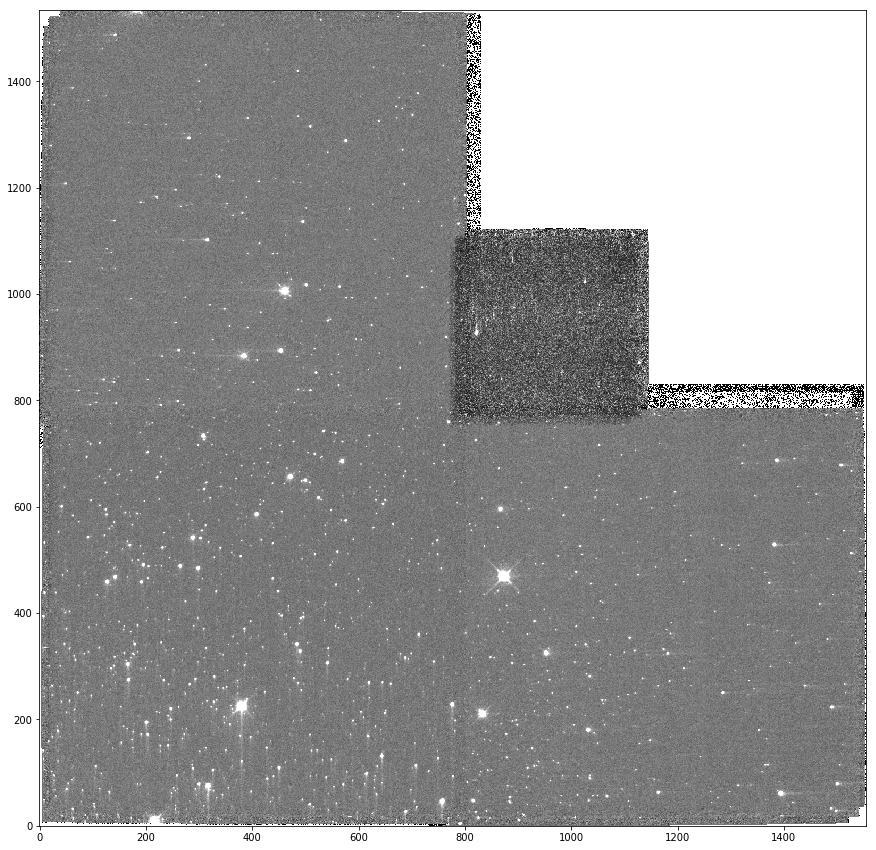

In [9]:
drz = fits.getdata('final_drz_sci.fits')
plt.figure(figsize=(15, 15))
plt.imshow(drz, cmap='gray', vmin=-0.1, vmax=0.5, origin='lower')

## 6. Illustration of the Effects of Sensitivity Variation on Drizzling

The effect of drizzling images with different detector sensitivies, while tangible, is sometimes difficult to _visualize_ in noisy data, especially when drizzling multiple dithered images that can blur the borders between chips.

In this section we produce a simple simulation of observing a constant intensity "blank sky". We then make a copy of this image and apply sensitivity equalization to it. Finally we drizzle both images and compare them side-by-side.

### Simulate an Image of Constant "Blank Sky" Background

In this simple simulation we assume only Poisson noise.

In [10]:
with fits.open(backup_image, mode='update') as h:
    # get chip inverse-sensitivity:
    phot1 = h[1].header['PHOTFLAM']
    phot2 = h[2].header['PHOTFLAM']
    phot3 = h[3].header['PHOTFLAM']
    phot4 = h[4].header['PHOTFLAM']
    
    # get chip WCS:
    w1 = HSTWCS(h, ext=1)
    w2 = HSTWCS(h, ext=2)
    w3 = HSTWCS(h, ext=3)
    w4 = HSTWCS(h, ext=4)
    ref_pscale = w4.idcscale
    
    # get chip gain:
    cmdgain = h[0].header['ATODGAIN']
    gain1 = WFPC2_GAINS[1][cmdgain][0]
    gain2 = WFPC2_GAINS[2][cmdgain][0]
    gain3 = WFPC2_GAINS[3][cmdgain][0]
    gain4 = WFPC2_GAINS[4][cmdgain][0]
    
    # final drizzle scale:
    scale = 0.0996
    
    # simulated sky level ("true" sky is constant):
    sky = 10 * phot3

    # simulate observed counts assuming only Poisson noise:
    conv1a = gain1 * (w1.idcscale / ref_pscale)**2 / phot1
    conv1b = (gain4 / gain1**2) * (ref_pscale / scale)**2
    conv2a = gain2 * (w2.idcscale / ref_pscale)**2 / phot2
    conv2b = (gain4 / gain2**2) * (ref_pscale / scale)**2
    conv3a = gain3 * (w3.idcscale / ref_pscale)**2 / phot3
    conv3b = (gain4 / gain3**2) * (ref_pscale / scale)**2
    conv4a = gain4 * (w4.idcscale / ref_pscale)**2 / phot4
    conv4b = (1.0 / gain4) * (ref_pscale / scale)**2

    h[1].data[:, :] = np.random.poisson(conv1a * sky, h[1].data.shape) * conv1b
    h[2].data[:, :] = np.random.poisson(conv2a * sky, h[2].data.shape) * conv2b
    h[3].data[:, :] = np.random.poisson(conv3a * sky, h[3].data.shape) * conv3b
    h[4].data[:, :] = np.random.poisson(conv4a * sky, h[4].data.shape) * conv4b

# make a copy of this file:
photeq_image = 'simulation_eq.fits'
if os.path.isfile(photeq_image):
    os.remove(photeq_image)
shutil.copy2(backup_image, photeq_image)

# apply equalization to the image copy:
photeq.photeq(files=photeq_image, ref_phot_ext=3, readonly=False)

***** drizzlepac.photeq started on 2019-01-08 05:07:40.687868


      Version 0.2 (06-Nov-2015)


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'simulation_eq.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'simulation_eq.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


### Drizzle the Original Simulated Image and the Equalized Image

In [11]:
astrodrizzle.AstroDrizzle(
    backup_image,
    output='nonequalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

astrodrizzle.AstroDrizzle(
    photeq_image,
    output='equalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

Setting up logfile :  astrodrizzle.log


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:07:40.791 (08/01/2019)


==== Processing Step  Initialization  started at  05:07:40.794 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3183097423576  -0.8651997450779788  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step  Initialization  finished at  05:07:41.090 (08/01/2019)


==== Processing Step  Static Mask  started at  05:07:41.092 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:07:41.093 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:07:41.09 (08/01/2019)


==== Processing Step  Subtract Sky  finished at  05:07:41.139 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:07:41.141 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3183097423576  -0.8651997450779788  


CRPIX : 1664.0  1642.0  


CD1_1 CD1_2  : 2.4758849093192705e-06  -1.2407891078819849e-05  


CD2_1 CD2_2  : -1.2407891078819849e-05  -2.4758849093192705e-06  


NAXIS : 3328  3284


-Generating simple FITS output: simulation_single_sci.fits


==== Processing Step  Separate Drizzle  finished at  05:07:42.892 (08/01/2019)


==== Processing Step  Create Median  started at  05:07:42.894 (08/01/2019)


==== Processing Step  Blot  started at  05:07:42.895 (08/01/2019)


==== Processing Step  Blot  finished at  05:07:42.896 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:07:42.898 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:07:42.898 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3183097423576  -0.8651997450779788  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1522  1502


-Generating simple FITS output: nonequalized_sci.fits


Writing out image to disk: nonequalized_sci.fits


Writing out image to disk: nonequalized_wht.fits


==== Processing Step  Final Drizzle  finished at  05:07:45.49 (08/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 05:07:45.502 (08/01/2019).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2963 sec.


            Static Mask          0.0007 sec.


           Subtract Sky          0.0445 sec.


       Separate Drizzle          1.7504 sec.


          Create Median          0.0000 sec.


                   Blot          0.0010 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          2.6003 sec.


   ====================          ====================


                  Total          4.6931 sec.


Trailer file written to:  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:07:45.553 (08/01/2019)


==== Processing Step  Initialization  started at  05:07:45.556 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3183097423576  -0.8651997450779788  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step  Initialization  finished at  05:07:45.830 (08/01/2019)


==== Processing Step  Static Mask  started at  05:07:45.832 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:07:45.833 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:07:45.834 (08/01/2019)


==== Processing Step  Subtract Sky  finished at  05:07:45.878 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:07:45.879 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3183097423576  -0.8651997450779788  


CRPIX : 1664.0  1642.0  


CD1_1 CD1_2  : 2.4758849093192705e-06  -1.2407891078819849e-05  


CD2_1 CD2_2  : -1.2407891078819849e-05  -2.4758849093192705e-06  


NAXIS : 3328  3284


-Generating simple FITS output: simulation_eq_single_sci.fits


==== Processing Step  Separate Drizzle  finished at  05:07:47.63 (08/01/2019)


==== Processing Step  Create Median  started at  05:07:47.637 (08/01/2019)


==== Processing Step  Blot  started at  05:07:47.638 (08/01/2019)


==== Processing Step  Blot  finished at  05:07:47.63 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:07:47.641 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:07:47.642 (08/01/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3183097423576  -0.8651997450779788  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.41390872698103e-06  -2.7131790149939664e-05  


CD2_1 CD2_2  : -2.7131790149939664e-05  -5.41390872698103e-06  


NAXIS : 1522  1502


-Generating simple FITS output: equalized_sci.fits


Writing out image to disk: equalized_sci.fits


Writing out image to disk: equalized_wht.fits


==== Processing Step  Final Drizzle  finished at  05:07:50.270 (08/01/2019)


AstroDrizzle Version 2.2.6 is finished processing at 05:07:50.273 (08/01/2019).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2743 sec.


            Static Mask          0.0007 sec.


           Subtract Sky          0.0438 sec.


       Separate Drizzle          1.7560 sec.


          Create Median          0.0000 sec.


                   Blot          0.0010 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          2.6282 sec.


   ====================          ====================


                  Total          4.7040 sec.


Trailer file written to:  astrodrizzle.log


### Display The Results of the Simulation Side-by-Side

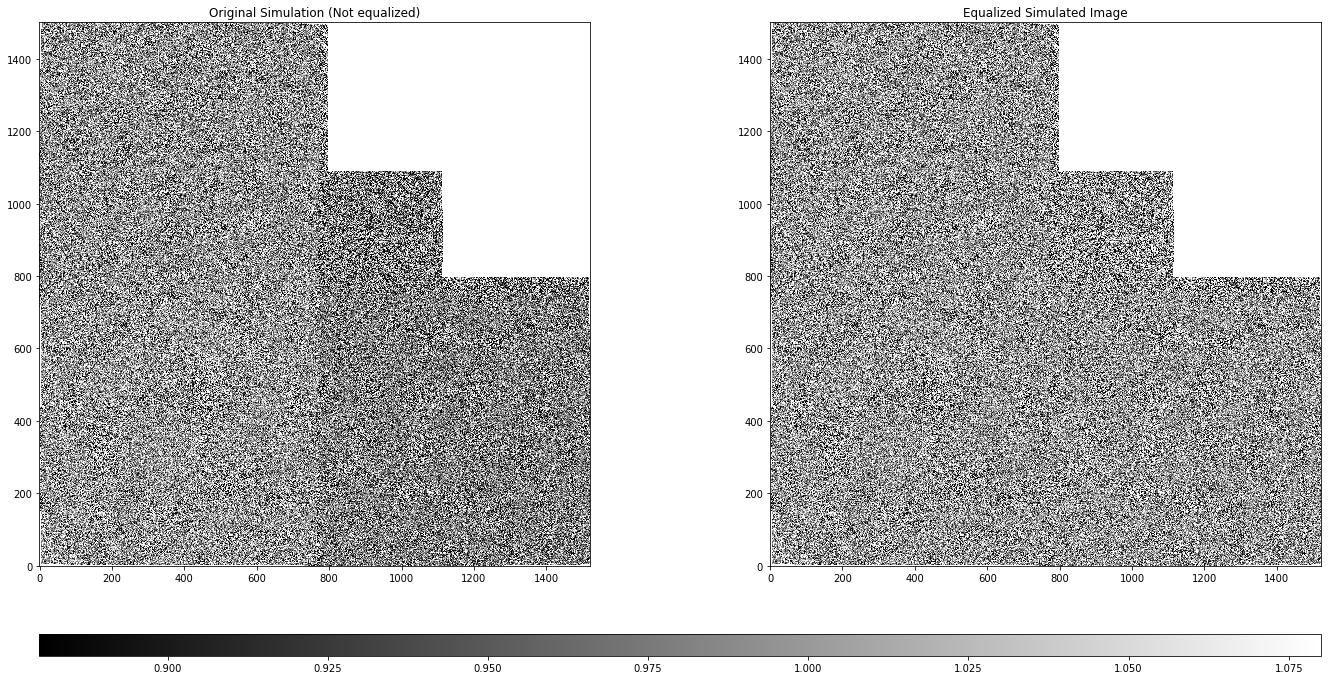

In [12]:
drz_noneq = fits.getdata('nonequalized_sci.fits')
drz_eq = fits.getdata('equalized_sci.fits')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 10))
im1 = ax1.imshow(drz_noneq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax1.set_title('Original Simulation (Not equalized)')
im2 = ax2.imshow(drz_eq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax2.set_title('Equalized Simulated Image')

x1 = ax1.get_position().get_points().flatten()[0]
x2 = ax2.get_position().get_points().flatten()[2] - x1
ax_cbar = fig.add_axes([x1, 0, x2, 0.03])
plt.colorbar(im1, cax=ax_cbar, orientation='horizontal')

# About this Notebook

    Author: M. Cara, STScI Data Analysis Tools Branch
    Updated: December 14, 2018